In [3]:
# imoprt libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob # allows us to list all files to a directory
import IPython
import IPython.display as ipd # to play the Audio Files

import librosa # main package for working with Audio Data
import librosa.display

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , confusion_matrix , ConfusionMatrixDisplay , classification_report

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import comms


In [4]:
# Make a list of all the wav files in the dataset and store them in a variable
audio_files = glob("C:/Users/Rohan Mahesh Rao/Documents/PES1UG20EC156/Sem 6/ML/project/gtzan/Data/genres_original/*/*.wav")
audio_files = [path.replace('//', '/') for path in audio_files]
print(type(audio_files))


<class 'list'>


In [5]:
# load the audio file and show raw data and sample rate
y, sr = librosa.load(audio_files[0])
print("Y is a numpy array:", y)
print("Shape of Y:", y.shape)
print("Sample Rate:", sr)

Y is a numpy array: [ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847]
Shape of Y: (661794,)
Sample Rate: 22050


In [6]:
def visualise_song(filename):
    
    y, sr = librosa.load(filename, sr=None)

    # turn raw data array to pd series and plot the audio example
    pd.Series(y).plot(figsize=(8,2), title="Raw Audio Example", color='green');

    # Use STFT on raw audio data
    D = librosa.stft(y)
    # convert from aplitude to decibel values by taking the absolute value of D in reference what the max value would be
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    # see the shape of transformed data
    print("New shape of transformed data", S_db.shape)
    
    # plot transformed data as spectogram
    fig, ax = plt.subplots(figsize=(3,3))
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax)
    ax.set_title('Spectogram Example', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f');

def get_mfcc(y,sr):

    # Mel-frequency cepstral coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mfcc_mean_vars = []
 
    for i in range (20):

        mfcc_mean_vars.append(np.mean(mfcc[i]))
        mfcc_mean_vars.append(np.var(mfcc[i]))

    mfcc_mean_vars = np.array(mfcc_mean_vars)

    mfcc_mean_vars = mfcc_mean_vars.tolist()

    return mfcc_mean_vars

In [7]:
#### The audio feature extraction fucntion ##########

## inputs must be of type string

import librosa
import numpy as np

def extract_features(filename):

    y, sr = librosa.load(filename, sr=None)

    visualise_song(filename)

    mfcc_values = get_mfcc(y,sr) #1d

    # Spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

    c_mean = np.mean(np.mean(spectral_centroid))
    b_mean = np.mean(np.mean(spectral_bandwidth))
    r_mean = np.mean(np.mean(spectral_rolloff))
    
    # Chroma features
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_stft_mean = np.mean(np.mean(chroma_stft))
    chroma_stft_var = np.var(np.var(chroma_stft))
    
    # Root-mean-square (RMS) energy
    rmse = librosa.feature.rms(y=y)
    rms_mean = np.mean(np.mean(rmse))
    rms_var = np.var(np.var(rmse))
    
    # Zero-crossing rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = np.mean(np.mean(zcr))
    zcr_var = np.var(np.var(zcr))
    
    # Harmony features
    harmonic_percussive = librosa.effects.hpss(y)
    harmony = librosa.feature.tonnetz(y=harmonic_percussive[0], sr=sr)
    harmony_mean = np.mean(np.mean(harmony))
    harmony_var = np.var(np.var(harmony))
    
    # Perceived loudness
    perceived_loudness = librosa.feature.spectral_flatness(y=y)
    perceived_loudness_mean = np.mean(np.mean(perceived_loudness))
    perceived_loudness_var = np.var(np.var(perceived_loudness))
    
    # Tempo
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr) # 0d 
    
    features = []
    features.append([chroma_stft_mean,
                                rms_mean,
                                c_mean,
                                b_mean,
                                r_mean,
                                zcr_mean,
                                harmony_mean,
                                perceived_loudness_mean,tempo])

    features_ls = features[0]

    features_ls.extend(mfcc_values)
   
 
    return features_ls


In [8]:
# load csv file
df = pd.read_csv("C:/Users/Rohan Mahesh Rao/Documents/PES1UG20EC156/Sem 6/ML/project/gtzan/Data/features_3_sec.csv")

In [9]:
df.head() # first 5 entries

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,classical.00000.0.wav,66149,0.255331,0.080393,0.032510,0.000075,1599.272683,18567.08102,1675.591596,20596.85173,...,55.257095,-1.666343,104.916260,4.525014,69.806412,-0.897889,110.099175,4.160629,194.109070,classical
1,classical.00000.1.wav,66149,0.231431,0.084894,0.031453,0.000059,1551.352817,28524.97073,1485.790068,28831.79451,...,50.988071,-1.546098,65.954590,7.157280,69.336983,2.718532,120.725609,-1.692275,150.527496,classical
2,classical.00000.2.wav,66149,0.225458,0.082233,0.041776,0.000222,1466.237496,45018.83405,1495.076539,10600.32107,...,81.254791,-4.686039,102.037117,-4.411082,60.409714,-2.694283,60.788319,3.038420,213.015579,classical
3,classical.00000.3.wav,66149,0.260866,0.082233,0.032749,0.000136,1435.850575,32270.30624,1585.998216,36208.01670,...,40.191471,2.764065,46.115536,-0.732678,60.197281,-8.223904,64.066719,1.734897,119.727020,classical
4,classical.00000.4.wav,66149,0.269611,0.084948,0.045156,0.000476,1477.712706,21448.14545,1569.311614,20844.07851,...,62.712025,-0.079564,89.584717,2.686025,65.182037,-1.290078,105.829987,-4.315813,79.882378,classical


In [10]:
df.shape # see the shape of df
# df.info() # infos about the samples, features and datatypes
#df.isnull().sum() # checking for missing values

(2998, 60)

In [11]:
# drop filename column and show new df first 5 entries
df = df.drop(labels=['length','filename','chroma_stft_var','rms_var','spectral_centroid_var','spectral_bandwidth_var','rolloff_var','zero_crossing_rate_var','harmony_var','perceptr_var'],axis=1)
df.head()

,chroma_stft_mean,rms_mean,spectral_centroid_mean,spectral_bandwidth_mean,rolloff_mean,zero_crossing_rate_mean,harmony_mean,perceptr_mean,tempo,mfcc1_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.255331,0.032510,1599.272683,1675.591596,2928.515625,0.106611,-0.000021,-0.000153,95.703125,-260.673401,...,55.257095,-1.666343,104.916260,4.525014,69.806412,-0.897889,110.099175,4.160629,194.109070,classical
1,0.231431,0.031453,1551.352817,1485.790068,2623.655161,0.108158,-0.000051,-0.000127,184.570312,-283.220093,...,50.988071,-1.546098,65.954590,7.157280,69.336983,2.718532,120.725609,-1.692275,150.527496,classical
2,0.225458,0.041776,1466.237496,1495.076539,2536.280048,0.095061,-0.000047,-0.000137,95.703125,-263.814972,...,81.254791,-4.686039,102.037117,-4.411082,60.409714,-2.694283,60.788319,3.038420,213.015579,classical
3,0.260866,0.032749,1435.850575,1585.998216,2673.678448,0.092811,-0.000074,-0.000073,95.703125,-275.855652,...,40.191471,2.764065,46.115536,-0.732678,60.197281,-8.223904,64.066719,1.734897,119.727020,classical
4,0.269611,0.045156,1477.712706,1569.311614,2783.580604,0.090494,-0.000068,-0.000101,184.570312,-240.182312,...,62.712025,-0.079564,89.584717,2.686025,65.182037,-1.290078,105.829987,-4.315813,79.882378,classical


In [12]:
# import labelencoder and scaler
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.preprocessing import StandardScaler
encoder = LabelEncoder()
scaler = StandardScaler()

data = df.iloc[:, :-1] # obtain metadata
labels = df.iloc[:, -1] # get labels column
labels.to_frame() # change datatype to pandas dataframe

print(labels)

0       classical
1       classical
2       classical
3       classical
4       classical
          ...    
2993        metal
2994        metal
2995        metal
2996        metal
2997        metal
Name: label, Length: 2998, dtype: object


In [13]:
# assign x and y, scale x and encode y
x = np.array(data, dtype = float)
x = scaler.fit_transform(data)

#### IMPORTANT #####

print (type(x))

########### the music features must also be of the type numpy.ndarray #################
y = encoder.fit_transform(labels)

print(y)

x.shape, y.shape

<class 'numpy.ndarray'>
[0 0 0 ... 2 2 2]


((2998, 49), (2998,))

In [14]:
# split data to train and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

## verify the type of x_train and x_test
print(type(x_train),type(x_test))

x_train.shape, x_test.shape, y_train.shape, y_test.shape

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


((2398, 49), (600, 49), (2398,), (600,))

In [15]:
def cross_val(classifier_rf, K, metadata, label, title, return_clf = False):
    # scores is used to give average of accuracy
    scores = []
    cv = KFold(n_splits=K)
    
    # K fold analysis, used for spliting the data into k batches
    for train_index, test_index in cv.split(metadata):
      
        X_train, y_train = metadata[train_index], label[train_index]
        X_test, y_test = metadata[test_index], label[test_index]

        classifier_rf.fit(X_train, y_train)
        scores.append(classifier_rf.score(X_test, y_test))
    
    # Display the average score
    print(title + " Cross-Validation Accuracy Score: ", round(np.mean(scores), 2))
    
    # returns the classifier if needed
    if(return_clf == True):
        return classifier_rf

def display_confusionMatrix(classifier_rf, X, y, title):
  cm = confusion_matrix(y, classifier_rf.predict(X), labels=classifier_rf.classes_)
  normed_c = (cm.T / cm.astype(np.float).sum(axis=1)).T
  disp = ConfusionMatrixDisplay(confusion_matrix=normed_c,
                                display_labels=classifier_rf.classes_)
  disp.plot(
      cmap=plt.cm.Blues
      )
  disp.ax_.set_title(title + " Confusion Matrix:")

(2398, 49)
(600, 49)
Model Accuracy :  0.9783333333333334
Cross Val Cross-Validation Accuracy Score:  0.93
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       200
           1       0.98      0.97      0.98       204
           2       0.99      0.99      0.99       196

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



C:\Users\Rohan Mahesh Rao\AppData\Local\Temp\ipykernel_20424\752599356.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  normed_c = (cm.T / cm.astype(np.float).sum(axis=1)).T


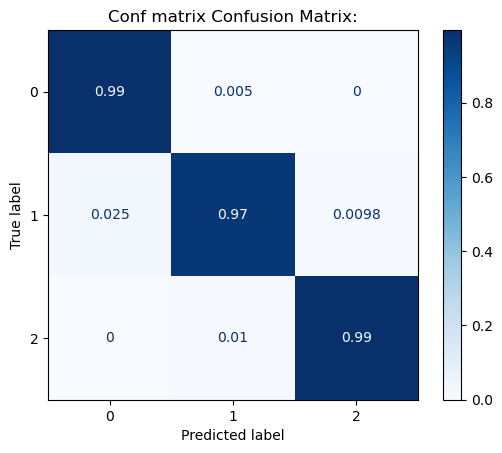

In [16]:
XGB=XGBClassifier()
XGB.fit(x_train,y_train)
print(x_train.shape)
print(x_test.shape)
y_pred = XGB.predict(x_test)

print("Model Accuracy : ",accuracy_score(y_test,y_pred))

cross_val(XGB, 5, x_test, y_test, title="Cross Val", return_clf = False)

print(classification_report(y_test, XGB.predict(x_test)))

display_confusionMatrix(XGB, x_test, y_test, title = "Conf matrix")

In [17]:
testpath = "C:/Users/Rohan Mahesh Rao/Documents/PES1UG20EC156/Sem 6/ML/project/gtzan/Data/genres_original/jazz/jazz.00003.wav"
# Play the first Audio file
ipd.Audio(testpath)

Classical = 0       Jazz = 1        Metal = 2       

In [18]:
original_labels = encoder.inverse_transform(y)
print(original_labels)

['classical' 'classical' 'classical' ... 'metal' 'metal' 'metal']


New shape of transformed data (1025, 1293)
['jazz', 92.0]


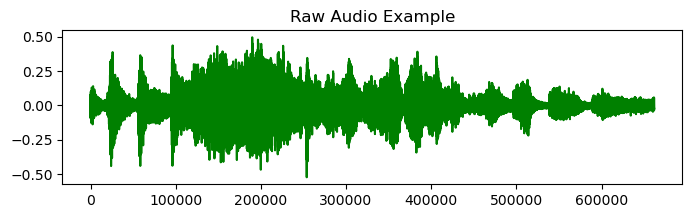

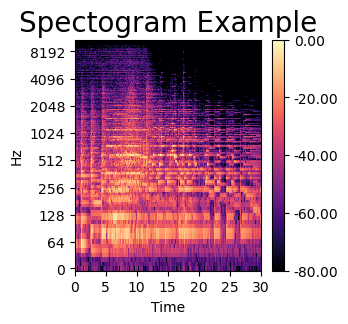

In [19]:
vals = extract_features(testpath)

extracted_tempo = np.around(vals[8])

label_ls = ["classical", "jazz", "metal"]

pred = XGB.predict([vals])

final_data = [str(label_ls[pred[0]]),extracted_tempo]
print(final_data)

#comms.run_comms(final_data)        #uncomment to push data to the esp 32